# K-Means Clustering

## Dependencies

Ensure that the required libraries have been installed locally as per the README.md file included in this project.

Run the following cell the import the required dependencies for this notebook.

In [139]:
# %pip install pandas numpy seaborn matplotlib scikit-learn kneed

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from IPython.display import display
from kneed import KneeLocator

## General Set Up

Suppress expected warning within the notebook. The KMeans module within sklearn is known to have memory leak issues. This is acknowledged and accepted within the project execution.


In [140]:
# Suppress KMeans warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

Set the theme for seaborn library plots.

In [141]:
# Set seaborn theme
sns.set_theme(style="whitegrid")

## Load Data

The following notebook was designed to perform a KMeans analysis on Air Quality and Health Outcome data.

Data has been aggregated to both the monthly and annual level for analysis. Additionally, the datasets have been divided into separate measures for Males and Females, as well as aggregated Genderless data.

The following defines the paths to the four possible datasets which can be analyzed with this model. This notebook has been designed to accommodate a dynamic number of Health Statistic columns, make it flexible to whichever dataset the user would like to analyze.

In [142]:
# Define possible dataset paths.
paths = [
    '../datasets/_integrated-data/processed-annual-genderless.csv',       # 0 - Annual Genderless
    '../datasets/_integrated-data/processed-annual-gendered.csv',         # 1 - Annual Gendered
    '../datasets/_integrated-data/processed-monthly-genderless.csv',      # 2 - Monthly Genderless
    '../datasets/_integrated-data/processed-monthly-gendered.csv'         # 3 - Monthly Gendered
]

Manually set the desired dataset to analyze based on following indexes:
- 0 : Annual Genderless Data
- 1 : Annual Gendered Data
- 2 : Monthly Genderless Data
- 3 : Monthly Gendered Data

In [143]:
# Choose the dataset to be used.
chosen_dataset = 3

Loads the chosen dataset to a dataframe.

In [144]:
# Read the chosen dataset.
df = pd.read_csv(paths[chosen_dataset])                                   

## Exploratory Data Analysis

Generate tables showing the head of the dataset, a summary of the object values, and a summary of the numerical values.

Provides an insight into the structure of the data, whether or not there are any missing values, and the general range of values to expect.

In [145]:
# Generate summary statistics for numerical columns.
numerical_summary_stats = df.describe().transpose()                                                         # Generate summary statistics for numerical columns.
numerical_summary_stats['missing_values'] = df.isnull().sum()                                               # Add missing values to the summary table.
numerical_summary_stats['present_values'] = df.notnull().sum()                                              # Add present values to the summary table.
numerical_summary_stats['datatype'] = df.dtypes                                                             # Add data types to the summary table.
numerical_summary_stats = numerical_summary_stats[['datatype', 'present_values', 'missing_values', 'min', '25%', '50%', '75%', 'max', 'std']]      # Select features and reorder table.

# Generate summary statistics for object columns.
object_summary_stats = df.describe(include=['O']).transpose()                                               # Generate summary statistics for object columns.
object_summary_stats['missing_values'] = df.isnull().sum()                                                  # Add missing values to the summary table.
object_summary_stats['present_values'] = df.notnull().sum()                                                 # Add present values to the summary table.
object_summary_stats['datatype'] = df.dtypes                                                                # Add data types to the summary table.
object_summary_stats = object_summary_stats[['datatype', 'present_values', 'missing_values', 'unique']]     # Select features and reorder table.

# Display the summary tables with titles.
print("Dataset Head:")                                                                                              # Display the dataset head title.
display(df.head().style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))                  # Display the dataset head. For better visualization, set the minimum width of the table headers to 100px.

print("\nObject Summary Statistics:")                                                                               # Display the object summary statistics.
display(object_summary_stats.style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))       # Display the object summary statistics. For better visualization, set the minimum width of the table headers to 100px.

print("\nNumerical Summary Statistics:")                                                                            # Display the numerical summary statistics.
display(numerical_summary_stats.style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))    # Display the numerical summary statistics. For better visualization, set the minimum width of the table headers to 100px.

Dataset Head:


,year-month,lhd,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma edp [f],asthma edp [m]
0,2014-07,Central Coast,0.100000,0.500000,0.600000,1.700000,10.600000,0.000000,29.800000,21.800000
1,2014-08,Central Coast,0.100000,0.300000,0.600000,1.900000,11.900000,0.000000,34.300000,32.000000
2,2014-09,Central Coast,0.100000,0.200000,0.600000,2.000000,12.500000,0.000000,28.400000,19.900000
3,2014-10,Central Coast,0.100000,0.200000,0.500000,2.300000,20.000000,0.100000,28.000000,19.500000
4,2014-11,Central Coast,0.100000,0.000000,0.300000,2.400000,20.800000,0.100000,28.000000,21.700000



Object Summary Statistics:


,datatype,present_values,missing_values,unique
year-month,object,1560,0,120
lhd,object,1560,0,13



Numerical Summary Statistics:


,datatype,present_values,missing_values,min,25%,50%,75%,max,std
CO ppm,float64,1560,0,0.000000,0.100000,0.133039,0.193861,0.456505,0.076290
NO pphm,float64,1560,0,0.000000,0.136131,0.275000,0.575000,4.576080,0.732098
NO2 pphm,float64,1560,0,0.000000,0.302769,0.484458,0.755558,2.072091,0.374287
OZONE pphm,float64,1560,0,0.623026,1.550000,1.850000,2.150000,3.213516,0.431311
PM10 µg/m³,float64,1560,0,8.095566,15.605194,18.511935,19.680863,45.265611,4.919421
SO2 pphm,float64,1560,0,0.000000,0.033193,0.068814,0.100000,0.252773,0.047696
asthma edp [f],float64,1560,0,4.600000,19.757692,28.811538,40.900000,99.900000,15.288249
asthma edp [m],float64,1560,0,2.800000,19.100000,26.600000,36.025000,105.100000,13.584746


## Feature Extraction

In [146]:
# Drop the date and local health district columns
df = df.drop(columns=df.columns[:2])                                                                   # Drop the first 2 columns

# Define the possible pollutants in the dataset
possible_pollutants = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']        # Possible features

# Extract columns
pollutant_columns = [col for col in df.columns if col in possible_pollutants]                          # Extract pollutant columns
health_stat_columns = [col for col in df.columns if col not in pollutant_columns]                      # Extract health stat columns

## Visualisation of Data via Heatmap

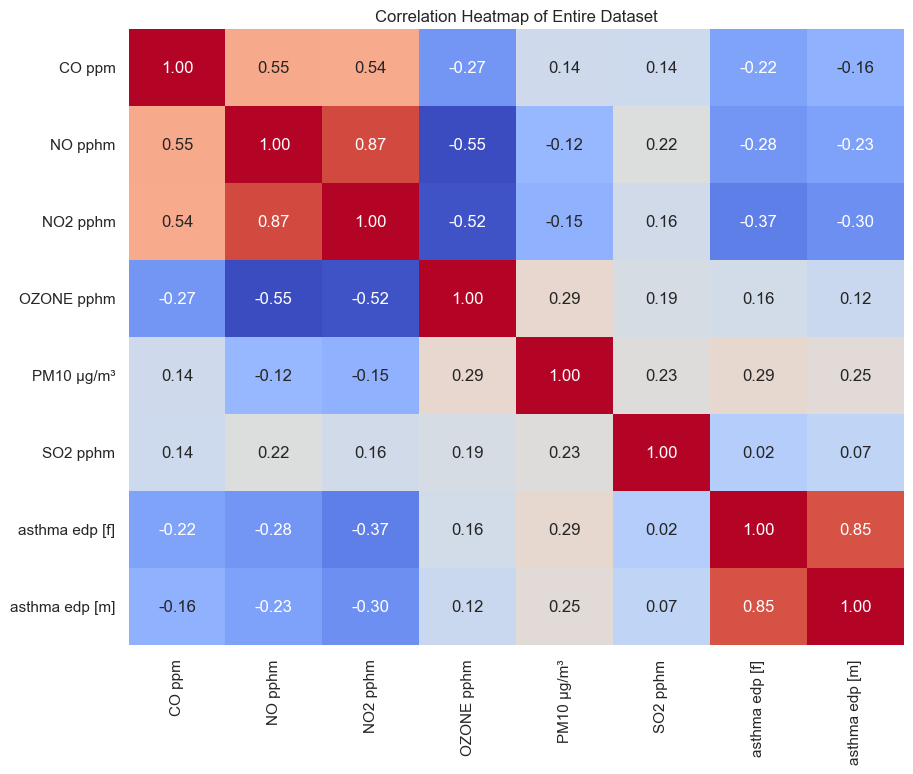

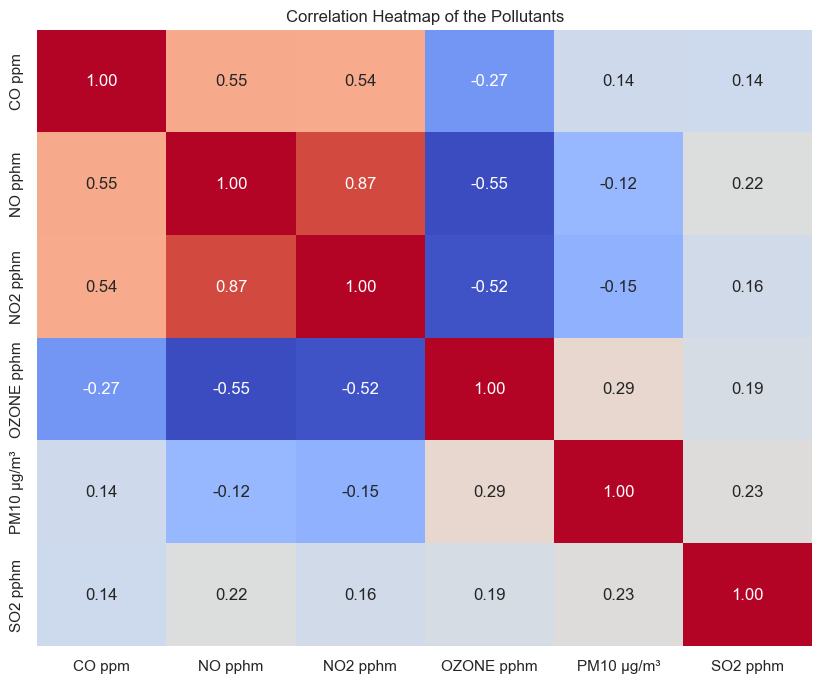

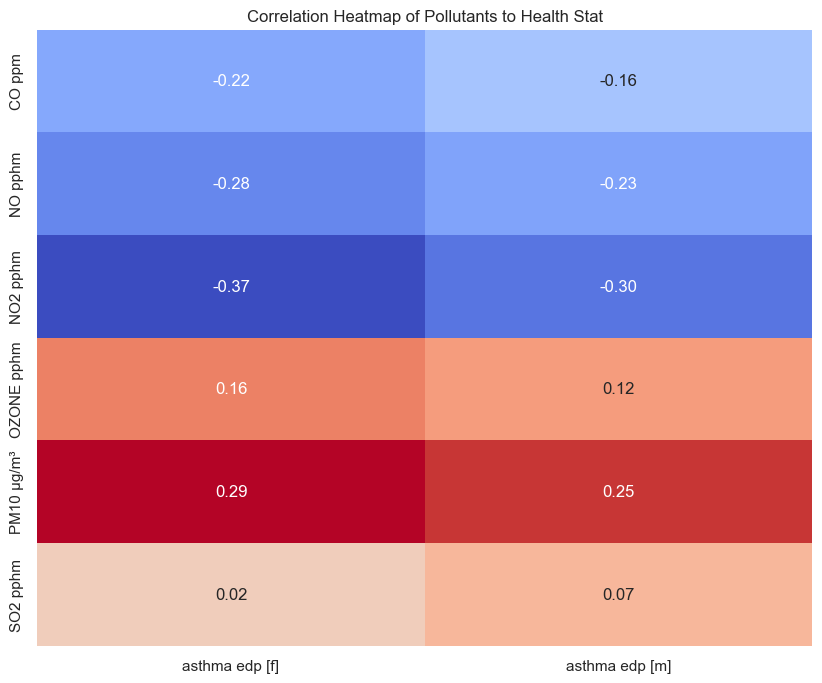

In [147]:
# Correlation heatmap of the entire dataset
plt.figure(figsize=(10, 8))                                                          # Set the figure size
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f", cbar=False)           # Create the heatmap
plt.title('Correlation Heatmap of Entire Dataset')                                   # Set the title
plt.show()                                                                           # Display the plot

# Correlation heatmap of the health statistics
plt.figure(figsize=(10, 8))                                                                            # Set the figure size
sns.heatmap(df[pollutant_columns].corr(), cmap='coolwarm', annot=True, fmt=".2f", cbar=False)         # Create the heatmap
plt.title('Correlation Heatmap of the Pollutants')                                                    # Set the title
plt.show()                                                                                            # Display the plot

# Correlation heatmap of pollutant columns to health stat column
pollutant_health_corr = df[pollutant_columns + health_stat_columns].corr().loc[pollutant_columns, health_stat_columns]     # Extract the correlation matrix
plt.figure(figsize=(10, 8))                                                                                                # Set the figure size
sns.heatmap(pollutant_health_corr, cmap='coolwarm', annot=True, fmt=".2f", cbar=False)                                     # Create the heatmap
plt.title('Correlation Heatmap of Pollutants to Health Stat')                                                              # Set the title
plt.show()                                                                                                                 # Display the plot

## Scale Data for Analysis

In [148]:
# Scale pollutant data.
scaler = StandardScaler()                                                               # Create a scaler
pollutant_columns_scaled = scaler.fit_transform(df[pollutant_columns])                  # Scale pollutant columns

## Find Optimal Number of Clusters via PCA

Principle Component Analysis (PCA) is utilized to reduce the dimensionality of a dataset while preserving as much of the variance as possible. It transforms correlated variables into a smaller set of uncorrelated variables, therefore reducing the number of components needed for analysis.

A 'minimum threshold' of 0.8 has been set for determining the appropriate number of components. This means that we are satisfied once we have enough components to explain 80% of the variance.

By looking at the Cumulative Explained Variance of Components, we see that 3 components explain roughly 87% of the variance in the data. Therefore, we can reduce our analysis from 6 pollutant features to 3 components.

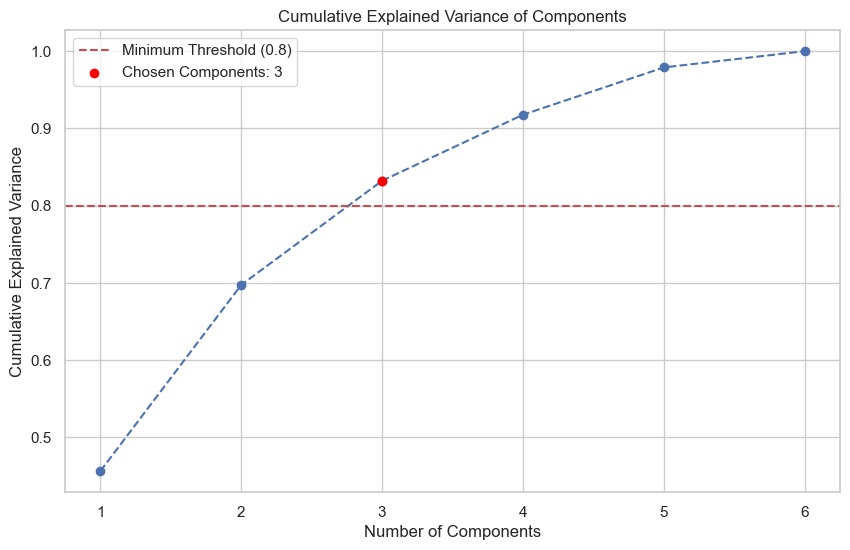

In [149]:
# Find the optimal number of clusters.
pca = PCA()                                                       # Create a PCA object
pca.fit(pollutant_columns_scaled)                                 # Fit the PCA object to the scaled pollutant columns
explained_variance = pca.explained_variance_ratio_                # Extract the explained variance of components

# Print the explained variance of components.
cumulative_variance = 0                                           # Set the cumulative variance to 0
n_components = None                                               # Set the number of components to None

# Find the number of components that explain at least 80% of the variance.
for i, variance in enumerate(explained_variance):                                       # Iterate over the explained variance
    cumulative_variance += variance                                                     # Add the variance to the cumulative variance
    if cumulative_variance >= 0.8 and n_components is None:                             # If the cumulative variance is at least 0.8 and the number of components is None
        n_components = i + 1                                                            # Set the number of components to the current index + 1
        break                                                                           # Break the loop

# Plot the cumulative explained variance of components.
plt.figure(figsize=(10, 6))                                                                                                                    # Create a figure
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')                                       # Plot the cumulative explained variance
plt.xlabel('Number of Components')                                                                                                             # Set the x-axis label
plt.ylabel('Cumulative Explained Variance')                                                                                                    # Set the y-axis label
plt.title('Cumulative Explained Variance of Components')                                                                                       # Set the title
plt.axhline(y=0.8, color='r', linestyle='--', label='Minimum Threshold (0.8)')                                                                 # Add a horizontal line at 0.8
plt.scatter(n_components, explained_variance.cumsum()[n_components - 1], color='red', label=f'Chosen Components: {n_components}', zorder=5)    # Add a point at the chosen number of components
plt.legend()                                                                                                                                   # Add a legend
plt.show()                                                                                                                                     # Show the plot

## Perform PCA with the Chosen Number of Components

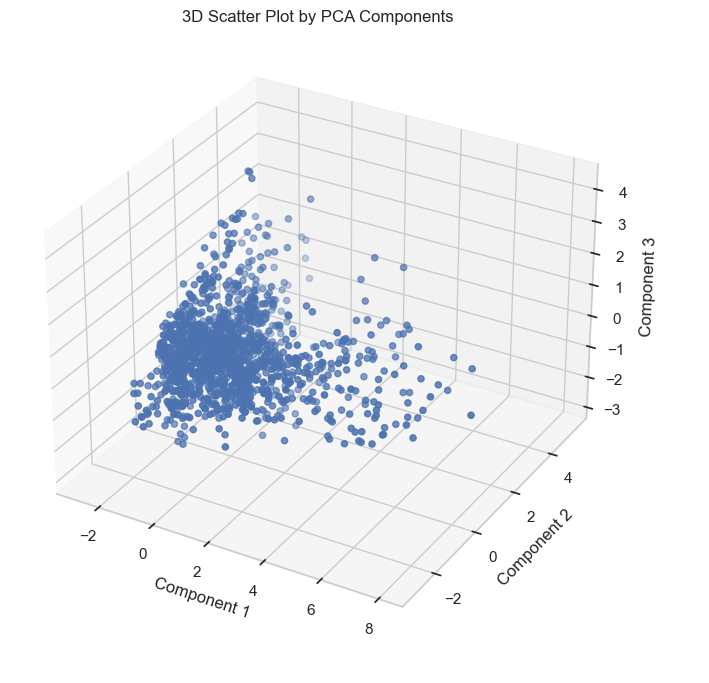

In [150]:
# Perform PCA with the chosen number of components.
pca = PCA(n_components=n_components)                                # Create a PCA object with the chosen number of components
pca.fit(pollutant_columns_scaled)                                   # Fit the PCA object to the scaled pollutant columns
scores_pca = pca.transform(pollutant_columns_scaled)                # Extract the transformed pollutant columns

# Visualize the transformed data.
fig = plt.figure(figsize=(10, 8))                                   # Create a figure
ax = fig.add_subplot(111, projection='3d')                          # Create a 3D axis
ax.scatter(scores_pca[:, 0], scores_pca[:, 1], scores_pca[:, 2])    # Scatter plot the transformed data
ax.set_xlabel('Component 1')                                        # Set the x-axis label
ax.set_ylabel('Component 2')                                        # Set the y-axis label
ax.set_zlabel('Component 3')                                        # Set the z-axis label
ax.set_title('3D Scatter Plot by PCA Components')                   # Set the title

# Add text to the right of the plot
ax.text2D(1.12, -.02, ' ', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')  # Add empty text to the bottom right of the plot to extend margins and ensure that the labels are not cut off

# Show the plot
plt.show()                                                          # Show the plot

## Find the Optimal Number of Clusters via the Elbow Method

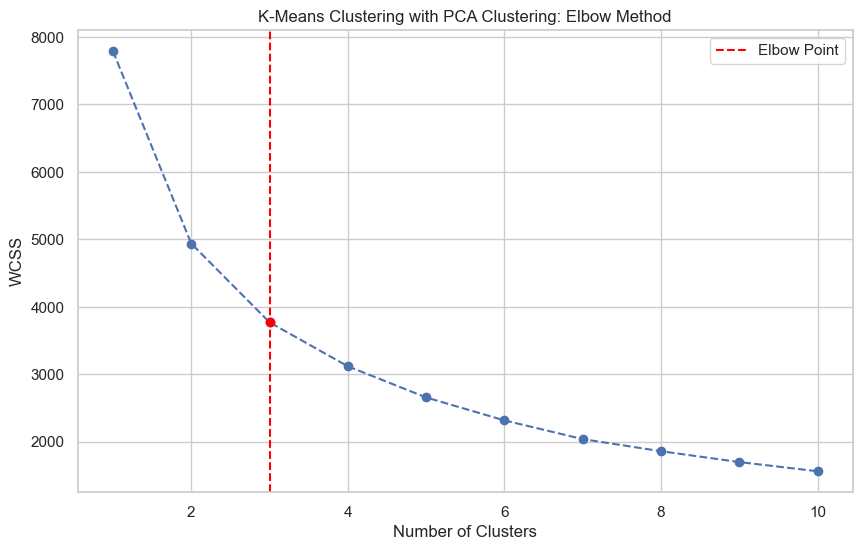

In [151]:
# Use the elbow method to find the optimal number of clusters.
wcss = []                                                                                              # Create an empty list to store the within-cluster sum of squares
for i in range(1, 11):                                                                                 # Iterate over the range from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=88)          # Create a KMeans object with the current number of clusters
    kmeans.fit(scores_pca)                                                                             # Fit the KMeans object to the PCA scores
    wcss.append(kmeans.inertia_)                                                                       # Append the within-cluster sum of squares to the list

# Identify the elbow point using KneeLocator
kl = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')                           # Create a KneeLocator object
elbow = kl.elbow                                                                                       # Extract the elbow point

# Plot the elbow method graph.
plt.figure(figsize=(10, 6))                                                                            # Create a figure
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')                                               # Plot the within-cluster sum of squares
plt.xlabel('Number of Clusters')                                                                       # Set the x-axis label
plt.ylabel('WCSS')                                                                                     # Set the y-axis label
plt.title('K-Means Clustering with PCA Clustering: Elbow Method')                                      # Set the title
plt.axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point')                                # Add a vertical line at the elbow point
plt.scatter(elbow, wcss[elbow - 1], color='red', zorder=5)                                             # Add a point at the chosen number of clusters
plt.legend()                                                                                           # Add a legend
plt.show()                                                                                             # Show the plot

### Evaluate Elbow Point
Silhouette, Calinski Harabasz, Davies Bouldin and Inertia Scores

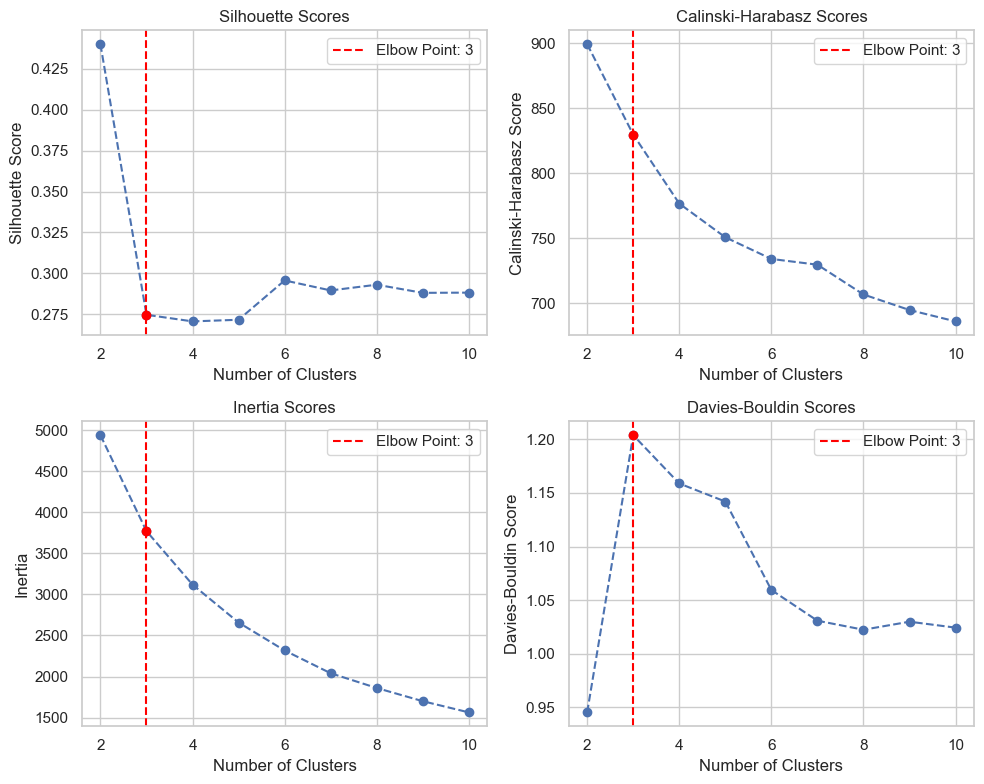

In [152]:
# Calculate metrics for each number of clusters
silhouette_scores = []                                                                             # Create an empty list to store silhouette scores
calinski_harabasz_scores = []                                                                      # Create an empty list to store Calinski-Harabasz scores
davies_bouldin_scores = []                                                                         # Create an empty list to store Davies-Bouldin scores
inertia_scores = []                                                                                # Create an empty list to store inertia scores

# Calculate metrics for each number of clusters
for i in range(2, 11):                                                                             # Iterate over the range from 2 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=88)      # Create a KMeans object with the current number of clusters
    kmeans.fit(scores_pca)                                                                         # Fit the KMeans object to the PCA scores
    cluster_labels = kmeans.labels_                                                                # Extract the cluster labels
    
    silhouette_scores.append(silhouette_score(scores_pca, cluster_labels))                         # Append the silhouette score to the list
    calinski_harabasz_scores.append(calinski_harabasz_score(scores_pca, cluster_labels))           # Append the Calinski-Harabasz score to the list
    davies_bouldin_scores.append(davies_bouldin_score(scores_pca, cluster_labels))                 # Append the Davies-Bouldin score to the list
    inertia_scores.append(kmeans.inertia_)                                                         # Append the inertia score to the list

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))                                        # Create subplots

# Plot silhouette scores
axes[0, 0].plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')                       # Plot silhouette scores
axes[0, 0].axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point: {elbow}')            # Add a vertical line at the elbow point
axes[0, 0].scatter(elbow, silhouette_scores[elbow - 2], color='red', zorder=5)                     # Add a point at the chosen number of clusters
axes[0, 0].set_title('Silhouette Scores')                                                          # Set the title
axes[0, 0].set_xlabel('Number of Clusters')                                                        # Set the x-axis label
axes[0, 0].set_ylabel('Silhouette Score')                                                          # Set the y-axis label
axes[0, 0].legend()                                                                                # Add a legend

# Plot Calinski-Harabasz scores
axes[0, 1].plot(range(2, 11), calinski_harabasz_scores, marker='o', linestyle='--')                # Plot Calinski-Harabasz scores
axes[0, 1].axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point: {elbow}')            # Add a vertical line at the elbow point
axes[0, 1].scatter(elbow, calinski_harabasz_scores[elbow - 2], color='red', zorder=5)              # Add a point at the chosen number of clusters
axes[0, 1].set_title('Calinski-Harabasz Scores')                                                   # Set the title
axes[0, 1].set_xlabel('Number of Clusters')                                                        # Set the x-axis label
axes[0, 1].set_ylabel('Calinski-Harabasz Score')                                                   # Set the y-axis label
axes[0, 1].legend()                                                                                # Add a legend

# Plot inertia scores
axes[1, 0].plot(range(2, 11), inertia_scores, marker='o', linestyle='--')                          # Plot inertia scores
axes[1, 0].axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point: {elbow}')            # Add a vertical line at the elbow point
axes[1, 0].scatter(elbow, inertia_scores[elbow - 2], color='red', zorder=5)                        # Add a point at the chosen number of clusters
axes[1, 0].set_title('Inertia Scores')                                                             # Set the title
axes[1, 0].set_xlabel('Number of Clusters')                                                        # Set the x-axis label
axes[1, 0].set_ylabel('Inertia')                                                                   # Set the y-axis label
axes[1, 0].legend()                                                                                # Add a legend

# Plot Davies-Bouldin scores
axes[1, 1].plot(range(2, 11), davies_bouldin_scores, marker='o', linestyle='--')                   # Plot Davies-Bouldin scores
axes[1, 1].axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point: {elbow}')            # Add a vertical line at the elbow point
axes[1, 1].scatter(elbow, davies_bouldin_scores[elbow - 2], color='red', zorder=5)                 # Add a point at the chosen number of clusters
axes[1, 1].set_title('Davies-Bouldin Scores')                                                      # Set the title
axes[1, 1].set_xlabel('Number of Clusters')                                                        # Set the x-axis label
axes[1, 1].set_ylabel('Davies-Bouldin Score')                                                      # Set the y-axis label
axes[1, 1].legend()                                                                                # Add a legend

# Show the plots
plt.tight_layout()                                                                                 # Adjust layout
plt.show()                                                                                         # Show the plot

# Perform K-means Analysis

In [153]:
# Perform K-Means clustering with the optimal number of clusters.
kmeans_pca = KMeans(n_clusters=elbow, init='k-means++', max_iter=300, n_init=10, random_state=88)      # Create a KMeans object with the optimal number of clusters
kmeans_pca.fit(scores_pca)                                                                             # Fit the KMeans object to the PCA scores

# Concatenate the original dataframe with the PCA scores and cluster labels.
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)                          # Concatenate the original dataframe with the PCA scores

# Rename the component columns.
df.columns.values[-n_components:] = [f'component {i+1}' for i in range(n_components)]                  # Rename the columns dynamically based on the number of components

# Add a 'cluster' column to the dataframe and map the cluster labels to more descriptive names.
df['cluster'] = kmeans_pca.labels_                                                                     # Add a 'cluster' column to the dataframe
cluster_labels = {i: f'Cluster {i+1}' for i in range(elbow)}                                           # Create a dynamic mapping for cluster labels
df['cluster'] = df['cluster'].map(cluster_labels)                                                      # Map the cluster labels to more descriptive names

# Display the first few rows of the dataframe.
display(df.head().style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))     # Display the first few rows of the dataframe. For better visualization, set the minimum width of the table headers to 100px.

,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma edp [f],asthma edp [m],component 1,component 2,component 3,cluster
0,0.100000,0.500000,0.600000,1.700000,10.600000,0.000000,29.800000,21.800000,-0.005871,-2.157609,-0.079007,Cluster 1
1,0.100000,0.300000,0.600000,1.900000,11.900000,0.000000,34.300000,32.000000,-0.383837,-1.834443,0.037814,Cluster 1
2,0.100000,0.200000,0.600000,2.000000,12.500000,0.000000,28.400000,19.900000,-0.571701,-1.679237,0.090429,Cluster 1
3,0.100000,0.200000,0.500000,2.300000,20.000000,0.100000,28.000000,19.500000,-0.980618,0.826570,-0.523677,Cluster 2
4,0.100000,0.000000,0.300000,2.400000,20.800000,0.100000,28.000000,21.700000,-1.547646,0.983493,-0.386389,Cluster 2


### Visualize K-Means Analysis

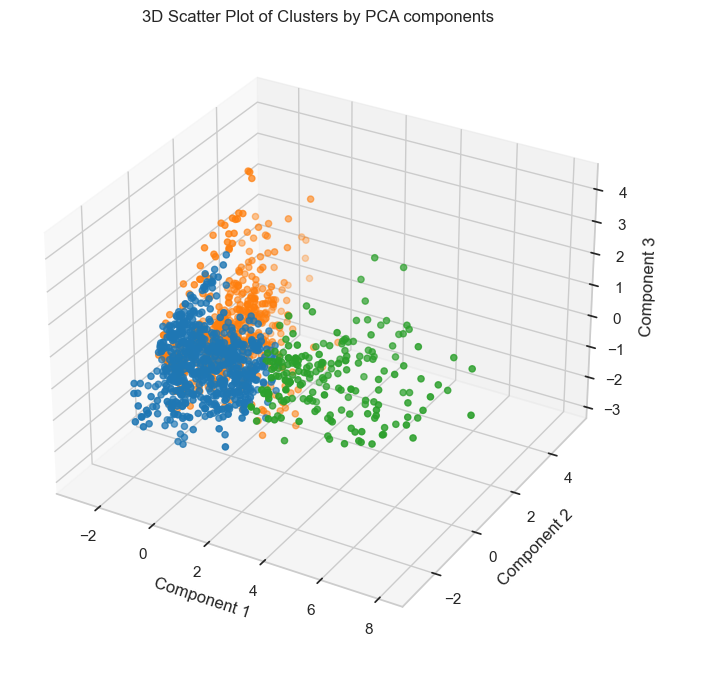

In [154]:
# Visualize the clusters in 2D.
if (n_components == 2):                                                                                # If the number of components is 2
    
    # Create a 2D scatter plot of the clusters.
    plt.figure(figsize=(10, 6))                                                                        # Create a figure
    sns.scatterplot(x='component 1', y='component 2', hue='cluster', data=df, palette='tab10')         # Create a scatter plot of the clusters
    plt.title('K-Means Clustering with PCA Clustering: 2D Visualization')                              # Set the title

    # Calculate and display metrics for each cluster
    silhouette_avg = silhouette_score(scores_pca, kmeans_pca.labels_)                                  # Calculate the silhouette score
    davies_bouldin_avg = davies_bouldin_score(scores_pca, kmeans_pca.labels_)                          # Calculate the Davies-Bouldin score
    calinski_harabasz_avg = calinski_harabasz_score(scores_pca, kmeans_pca.labels_)                    # Calculate the Calinski-Harabasz score

    # Set the text for the metrics
    metrics_text = (f"Silhouette Score: {silhouette_avg:.2f}\n"                                        # Set the text for the silhouette score
                    f"Davies-Bouldin Score: {davies_bouldin_avg:.2f}\n"                                # Set the text for the Davies-Bouldin score
                    f"Calinski-Harabasz Score: {calinski_harabasz_avg:.2f}")                           # Set the text for the Calinski-Harabasz score
    
    # Add the metrics text to the plot
    plt.text(1.1, 1, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')   # Add the metrics text to the plot

    # Show the plot
    plt.show()                                                                                         # Show the plot

# Visualize the clusters in 3D.
if (n_components == 3):                                                                                # If the number of components is 3
    
    # Extract the components.
    x_axis = df['component 1']                                                                         # Extract the x-axis
    y_axis = df['component 2']                                                                         # Extract the y-axis
    z_axis = df['component 3']                                                                         # Extract the z-axis

    # Set the colors for the clusters.
    palette = sns.color_palette('tab10', n_colors=3)                                                   # Create a color palette
    color_mapping = {                                                                                  # Create a color mapping for the clusters
        'Cluster 1': palette[0],                                                                       
        'Cluster 2': palette[1],
        'Cluster 3': palette[2]
    }
    colors = df['cluster'].map(color_mapping).values                                                   # Map cluster labels to colors and convert to array

    # Create a 3D scatter plot.
    fig = plt.figure(figsize=(10, 8))                                                                  # Create a figure
    ax = fig.add_subplot(111, projection='3d')                                                         # Add a 3D subplot
    scatter = ax.scatter(x_axis, y_axis, z_axis, c=colors)                                             # Create a scatter plot
    ax.set_xlabel('Component 1')                                                                       # Set the x-axis label
    ax.set_ylabel('Component 2')                                                                       # Set the y-axis label
    ax.set_zlabel('Component 3')                                                                       # Set the z-axis label
    ax.set_title('3D Scatter Plot of Clusters by PCA components')                                      # Set the title
    ax.text2D(1.12, -.02, ' ', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')  # Add empty text to the bottom right of the plot to extend margins and ensure that the labels are not cut off

    # Show the plot
    plt.show()                                                                                         # Show the plot

# More than 3 components
if (n_components > 3):
    print('Too many components to visualize in 2D or 3D.')                                             # Print a stating that there are too many components to visualize in 2D or 3D
    cluster_summary = df.groupby('cluster').mean()[pollutant_columns + health_stat_columns]            # Group the dataframe by cluster and calculate the mean of pollutant and health columns
    cluster_summary['Count'] = df['cluster'].value_counts()                                            # Add a 'Count' column to the cluster summary
    cluster_summary = cluster_summary.reset_index()                                                    # Reset the index of the cluster summary
    cluster_summary = cluster_summary.rename(columns={'index': 'Cluster'})                             # Rename the 'index' column to 'Cluster'
    display(cluster_summary)                                                                           # Display the cluster summary

## Evaluate Clusters

### Centroids

In [155]:
# Calculate the mean values of the original features for each cluster
centroid_evaluation = df.groupby('cluster').mean()[pollutant_columns + health_stat_columns]

# Display the centroid evaluation
display(centroid_evaluation.style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))

,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma edp [f],asthma edp [m]
cluster,,,,,,,,
Cluster 1,0.120726,0.404267,0.557647,1.700911,16.172365,0.038392,29.107636,26.482032
Cluster 2,0.115978,0.218571,0.403405,2.161042,21.051449,0.093509,36.433957,32.649713
Cluster 3,0.235861,2.200647,1.318326,1.315713,17.799624,0.088721,22.137436,21.962564


### Silhouette Analysis

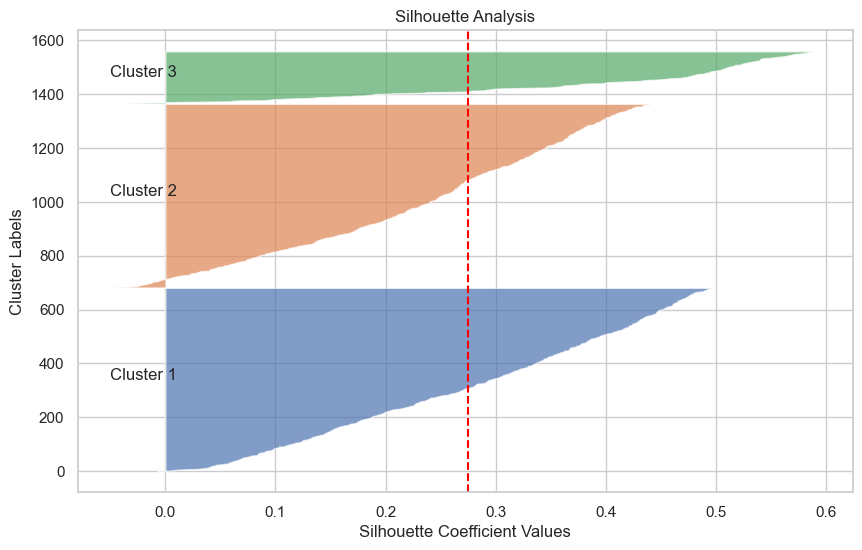

In [156]:
# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(scores_pca, kmeans_pca.labels_)                         # Get silhouette scores 

# Create a subplot for silhouette analysis
fig, ax = plt.subplots(figsize=(10, 6))                                                      # Create a figure and axis

# Plot silhouette scores for each cluster
y_lower, y_upper = 0, 0                                                                      # Initialize y-axis bounds
for i in range(elbow):                                                                       # Iterate over each cluster
    cluster_silhouette_vals = silhouette_vals[kmeans_pca.labels_ == i]                       # Get silhouette values for the current cluster
    cluster_silhouette_vals.sort()                                                           # Sort the silhouette values
    y_upper += len(cluster_silhouette_vals)                                                  # Update the upper bound
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)     # Fill the area for the current cluster
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), f'Cluster {i+1}')           # Add text label for the cluster
    y_lower = y_upper                                                                        # Update the lower bound

# Set labels and title
ax.set_xlabel('Silhouette Coefficient Values')                                               # Set x-axis label
ax.set_ylabel('Cluster Labels')                                                              # Set y-axis label
ax.set_title('Silhouette Analysis')                                                          # Set title
ax.axvline(x=silhouette_vals.mean(), color="red", linestyle="--")                            # Add a vertical line for the average silhouette score

# Show the plot
plt.show()                                                                                   # Display the plot

## Cluster Analysis for each Target Health Stat

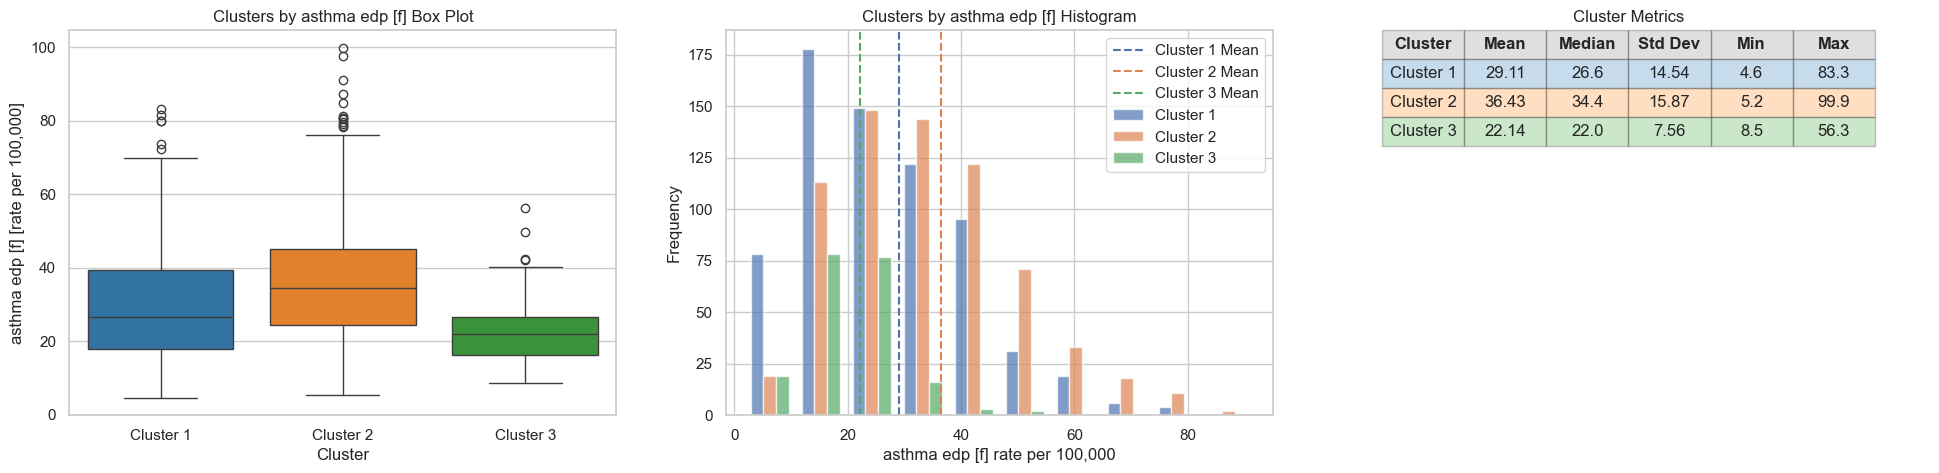

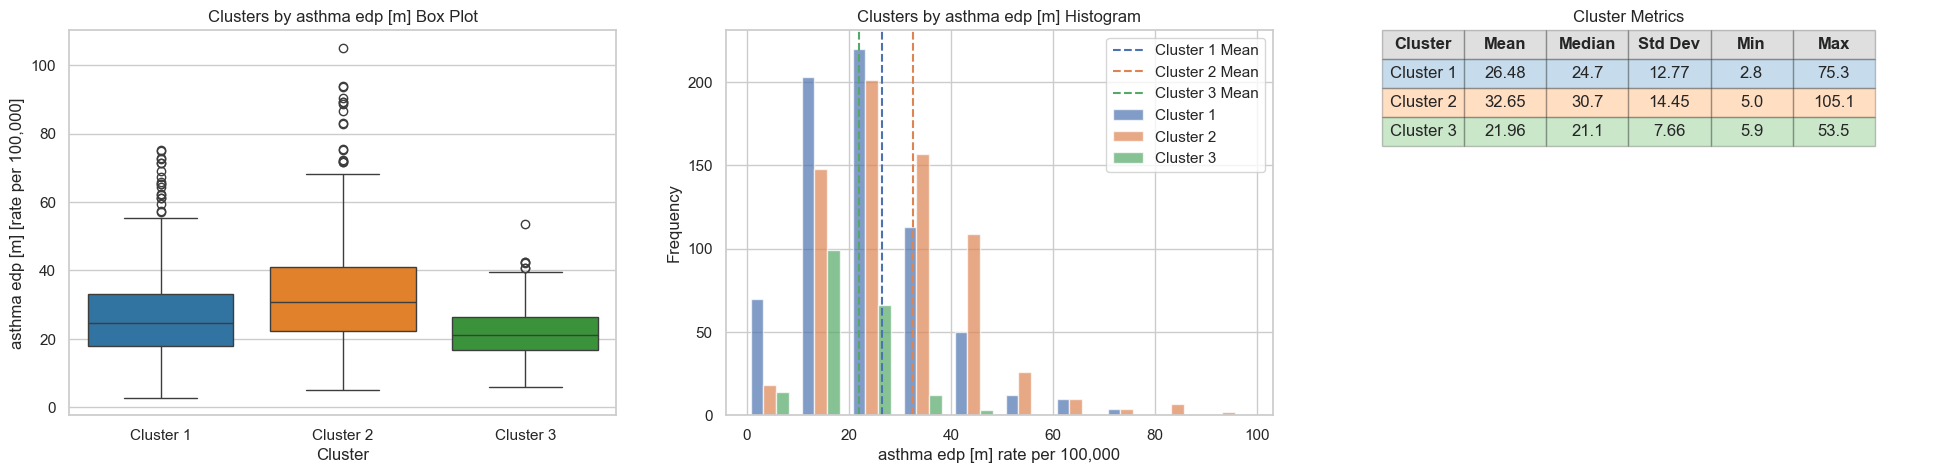

In [157]:
# Create sublplots for all health stat columns
for target_column in health_stat_columns:                                                                                 # Iterate over the health stat columns
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))                                                           # Create subplots

    # Boxplot
    sns.boxplot(x='cluster', y=target_column, data=df, ax=axes[0], palette='tab10', hue='cluster', dodge=False)           # Create a boxplot
    axes[0].set_title(f'Clusters by {target_column} Box Plot')                                                            # Set the title
    axes[0].set_xlabel('Cluster')                                                                                         # Set the x-axis label
    axes[0].set_ylabel(f'{target_column} [rate per 100,000]')                                                             # Set the y-axis label

    # Histogram
    min_value = df[target_column].min()                                                                                  # Extract the minimum value
    max_value = df[target_column].max()                                                                                  # Extract the maximum value
    bin_width = max(int((max_value - min_value) * 0.1), 1)                                                               # Ensure bin width is at least 1 to avoid division by zero
    bins = np.arange(int(min_value), int(max_value) + 1, bin_width)                                                      # Create bins
    clusters = df['cluster'].unique()                                                                                    # Extract unique clusters
    width = np.diff(bins)[0] / (len(clusters) + 1)                                                                       # Calculate the width of the bars

    # Plot histograms for each cluster
    for j, cluster in enumerate(clusters):                                                                               # Iterate over the clusters
        cluster_data = df[df['cluster'] == cluster][target_column]                                                       # Extract the cluster data
        cluster_mean = cluster_data.mean()                                                                               # Calculate the mean of the cluster data
        bar_positions = bins[:-1] + (j * width)                                                                          # Calculate the bar positions
        axes[1].bar(bar_positions, np.histogram(cluster_data, bins=bins)[0], width=width, label=cluster, alpha=0.7)      # Create a histogram for the cluster
        axes[1].axvline(cluster_mean, color=f'C{j}', linestyle='--', label=f'{cluster} Mean')                            # Add a vertical line for the cluster mean

    # Set the labels and title
    axes[1].set_xlabel(f'{target_column} rate per 100,000')                                                              # Set the x-axis label
    axes[1].set_ylabel('Frequency')                                                                                      # Set the y-axis label
    axes[1].set_title(f'Clusters by {target_column} Histogram')                                                          # Set the title
    axes[1].legend()                                                                                                     # Add a legend

    # Calculate and display metrics for each cluster
    metrics_data = []                                                                                                    # Create an empty list to store the metrics
    for idx, cluster in enumerate(clusters):                                                                             # Iterate over the clusters
        cluster_data = df[df['cluster'] == cluster][target_column]                                                       # Extract the cluster data
        mean = cluster_data.mean()                                                                                       # Calculate the mean
        median = cluster_data.median()                                                                                   # Calculate the median
        std_dev = cluster_data.std()                                                                                     # Calculate the standard deviation
        min_val = cluster_data.min()                                                                                     # Calculate the minimum value
        max_val = cluster_data.max()                                                                                     # Calculate the maximum value
        metrics_data.append([cluster, mean, median, std_dev, min_val, max_val])                                          # Append the metrics to the list

    # Create a dataframe from the metrics data
    metrics_df = pd.DataFrame(metrics_data, columns=['Cluster', 'Mean', 'Median', 'Std Dev', 'Min', 'Max'])              # Create a dataframe from the metrics data

    # Round the metrics to 2 decimal places
    metrics_df = metrics_df.round(2)                                                                                     # Round the metrics to 2 decimal places

    # Create table and adjust formatting
    axes[2].set_title('Cluster Metrics')                                                                                 # Set the title for the table
    axes[2].title.set_position([0.45, .9])                                                                               # Set the position of the title
    axes[2].axis('off')                                                                                                  # Turn off the axis for the table
    metrics_table = axes[2].table(                                                                                       # Create a table
        cellText=metrics_df.values,                                                                                      # Set the cell text to the values of the metrics dataframe
        colLabels=metrics_df.columns,                                                                                    # Set the column labels to the columns of the metrics dataframe
        cellLoc='center',                                                                                                # Set the cell location to the center
        loc='center', bbox=[0, 0.7, .9, 0.3]                                                                             # Set the location and bounding box
    )

    # Adjust table formatting
    metrics_table.auto_set_font_size(False)                                                                              # Disable auto font size scaling
    metrics_table.set_fontsize(12)                                                                                       # Set the font size

    # Set column width and background color
    for key, cell in metrics_table.get_celld().items():                                                                  # Iterate over the cells
        cell.set_width(0.15)                                                                                             # Set the width of the cells
        cell.set_alpha(0.25)                                                                                             # Set the opacity

        # Header row
        if key[0] == 0:                                                                                                
            cell.set_facecolor('gray')                                                                                   # Set header row to gray
            cell.set_text_props(weight='bold')                                                                           # Make headers bold 
        # Data rows
        else:
            cluster_name = metrics_df.iloc[key[0] - 1, 0]                                                                # Get the cluster name
            cell.set_facecolor(color_mapping[cluster_name])                                                              # Set the background color based on the cluster

    # Display the visualization
    plt.show()                                                                                                           # Display the plot